In [1]:
#basic

import numpy as np
import control as ct
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Import symbolic librery
from sympy import Function, Symbol, evalf, Matrix, lambdify, Subs, Derivative, re
from sympy import sign, sqrt, Abs

#solver of NLP problem
import cyipopt
from cyipopt import minimize_ipopt

# Import math Library
import math
import time

Sub programs

In [2]:

def fob_NMPC(du,uk_1,Hp,Hc,ysp1,q,r,Ts,x0m,x0,nu,ny,modelo):
    #xv = du + np.zeros((Hp,1))                        # du: decision variables Hc*nu
    
    ym = open_loop_sim(x0m,du,uk_1,Hp,nu,ny,Ts,modelo) # dimension Hp*ny
    Q = q*np.identity(Hp)                              # dimension Hp*ny x Hp*ny 
    R = r*np.identity(nu*nu)                           # dimension nu*nu
    ysp = np.asarray(ysp1)*np.ones((Hp,nu))            # dimension Hp*ny
    
    # Bias 
    e = np.asarray(x0) - np.asarray(x0m)               # mismatch at time step k
    ee = e * np.ones((Hp,nu))  
    y = ym + ee                                        # augmented vector of prediction plus bias
    
    # Objective function of the controller
    J = (y[:,0]-ysp[:,0]).T @ Q @ (y[:,0]-ysp[:,0])+ (y[:,1]-ysp[:,1]).T @ Q @ (y[:,1]-ysp[:,1])+ du.T @ R @ du
    
    return J

def open_loop_sim(x0m,du,uk_1,Hp,nu,ny,Ts,modelo):
    #ym = np.empty((Hp, 10))
    ym1 = []
    for k in range(Hp):
        uk_1 = uk_1 + du[0:nu] 
        ys   = odeint(jacketed_tank,x0,Ts,args=(uk_1,)) # integrate jacketed_tank(t,h,modelo,uk_1),[0 Ts],x0m) ;
        # ANN, fuzzy, NARX, NARMAX, NOE etc.
        #ym = np.append(ym, ys[-1])                     # dimension ny  
        ym1 += [[k, ys[-1]]]
        ym2 = np.array(ym1)     # list
        ym3 = ym2[0:len(ym2),1] # list array
        ym4 = np.vstack(ym3).astype(float)              # array
        #x0m = ym[k,:].T 
        #y = np.matrix('y;ym').T                        # dimension Hp*ny
    return ym4

def jacketed_tank(x,t,uk_1):

    #  Model parameters
    rho  = 1e3       
    Cp   = 4.18      
    At   = math.pi*(0.5)**2  
    k    = 7         
    lamb = 2.257e4
    Ti   = 40 
    # equation
    f1 = ( uk_1[0] - k*np.sqrt(np.abs(x[0])) ) / At
    f2 = ( rho*uk_1[0]*Cp*(Ti - x[1]) +  uk_1[1]*lamb )/ ( rho*At*x[1]*Cp ) 
    f = [f1,f2]
    return f

def jacketed_tank_plant(x,t,uk_1):
    #  Model parameters
    rho  = 1e3       
    Cp   = 4.18      
    At   = math.pi*(0.5)**2  
    k    = 7.0       
    lamb = 2.257e4
    Ti   = 40 
    f1 = ( uk_1[0] - k*np.sqrt(np.abs(x[0])) ) / At
    f2 = ( rho*uk_1[0]*Cp*(Ti - x[1]) +  uk_1[1]*lamb )/ ( rho*At*x[1]*Cp ) 
    f = [f1,f2]
    return f


def linearizacao_tank(X,U,t):
    #X[0]=pbh , x[1]= pwh , x[2]= q ,x[3]=fq , x[4]= zc
    #U[0]= f, u[1] = Zc
    #u = (40,90)
    #Constantes
    #  Model parameters
    rho  = 1e3       
    Cp   = 4.18*.96      
    At   = math.pi*(0.5)**2  
    k    = 7.0*.98       
    lamb = 2.257e4
    Ti   = 40 
    f1 = ( U[0] - k*sqrt(Abs(X[0])) ) / At
    f2 = ( rho*U[0]*Cp*(Ti - X[1]) +  U[1]*lamb )/ ( rho*At*X[1]*Cp ) 
    # out
    dxdt = Matrix([f1,f2])
    # Jacobian
    X1 = Matrix(X)
    U1 = Matrix(U)
    Ak = dxdt.jacobian(X1)
    Bk = dxdt.jacobian(U1)
    
    return [Ak,Bk]    

def lin_tankx0(Ak,Bk,xmk,UU):
    x0 = xmk[0]
    x1 = xmk[1]
    u0 = UU[0]
    u1 = UU[1]
    #uk3 = u(3)
    A = (Ak).evalf().subs({X0: x0, X1: x1, U0: u0, U1: u1})
    Anp = np.array(A)
    Anp[0][0] = 0
    B = (Bk).evalf().subs({X0: x0, X1: x1, U0: u0, U1: u1})
    Bnp = np.array(B)

    return Anp,Bnp


Controller parameters

In [3]:

nsim = 150         # number of steps
Hp   = 10          # prediction horizon
Hc   = 2           # control horizon
q    = 10          # weights on controlled variables 
r    = 0.1         # weights on control actions
Ts   = 0.1         # sampling time [=] min
ny   = 2
nu   = 2

# Noise
np.random.seed(42)
mean = 0
std = 1 
num_samples = nsim
noise = np.random.normal(mean, std, size=num_samples)


In [4]:

#u = [65,90]
TT = np.linspace(0,nsim)
X0 = Symbol('x0')
X1 = Symbol('x1')
U0 = Symbol('u0')
U1 = Symbol('u1')
X = [X0,X1]
U = [U0,U1]
[Ak,Bk] = linearizacao_tank(X,U,TT) # Calculo das Jacobianas

#--------------------------------------------------------------------------
# constraints on inputs
#--------------------------------------------------------------------------
umin  = np.array([5,5])    # lower bounds of inputs
umax  = np.array([20,30])  # upper bounds of inputs 
dumax = np.array([1,2])    # maximum variation of input moves
# Auxiliary matrices for using in the solver

Dumax = np.vstack((dumax,dumax))
                  
Dumin = -Dumax
auxM = np.vstack((np.eye(nu),np.zeros((nu,nu)))).T
auxM1 = np.vstack((np.eye(nu),np.eye(nu))).T
Mtil = np.vstack((auxM,auxM1))
Itil = np.vstack((np.eye(nu),np.eye(nu)))
Ain = np.vstack((Mtil,-Mtil))
Bin = lambda ukk_1: [np.tile(umax.reshape(2,1),(Hc,1)) - Itil@ukk_1, Itil@ukk_1 - np.tile(umin.reshape(2,1),(Hc,1))]
ineq_cons = {'type': 'ineq', 'fun' : lambda x: np.array([BBin[0][0][0] - x[0],
                                                         BBin[0][1][0] - x[1],
                                                    BBin[0][2][0] - x[0]-x[2],
                                                    BBin[0][3][0] - x[1]-x[3],
                                                         BBin[1][0][0] + x[0],
                                                         BBin[1][1][0] + x[1],
                                                    BBin[1][2][0] + x[0]+x[2],
                                                     BBin[1][3][0]+ x[1]+x[3]])}

#--------------------------------------------------------------------------
# Initial condition (steady-state preferentially)
#--------------------------------------------------------------------------
uk_1 = np.array([10,10])       # manipulated variable
x0 = np.array([2.0408,45.4])   # state variables
x0m = np.array([2.0408,45.4])
#--------------------------------------------------------------------------
 # initial guess
du0 = np.array([0.0, 0.0, 10.0, 10.0])

tcalc_h = []
uk_h    = []
J_k_h   = []
yp_h    = []
ym_h    = []
e_h     = []
sp_h    = []
du_h    = []
status_h = []

In [5]:

for k in range(100):
    #   k
    #   changes on set-points
    if k <= 50:
        ysp = np.array([3,50])
    else:
        ysp =  np.array([5,55])
    
    #control law 
    t = time.time()
    Ts = np.linspace(0,k)
    bnds =[(-1, 1), (-1, 1), (5, 20), (5, 30)]
    BBin = Bin(uk_1)
    fob = lambda du: fob_NMPC(du,uk_1,Hp,Hc,ysp,q,r,Ts,x0m,x0,nu,ny,jacketed_tank)
    res = minimize_ipopt(fob, du0, bounds=bnds, constraints = ineq_cons, options={'disp': 10,'max_iter': 100,'tol':1e-2})
    #print(res)
    #fval = minimize(fob, x0, bounds = bounds1, method='trust-constr', options={'gtol': 1e-2, 'disp': True})
    elapsed = time.time() - t
    #uk_1      =  res.x[2:4]                       # optimal input at time step k
    tcalc_h   += [[k,elapsed]]
    uk_h      += [[k, uk_1 + res.x[0:nu]]]      # du = fval.x 
    J_k_h     += [[k, res.fun]]                 # cost function
    status_h  += [[k, res.status]]              # cost function
    uk_1      =  uk_h[k][1]                       # optimal input at time step k
    duk = res.x[0:nu]
    print(uk_1)
    print(res.x)
    print(res.x[0:nu])
    # Plant
    # gPRoms, Hysys, Aspen, or Real Plant (opc)
    tspan =  np.linspace(0,k)
    if k <= 60:
        ys = odeint(jacketed_tank_plant,x0,tspan,args=(uk_1,))
    else:
        ys = odeint(jacketed_tank_plant,x0,tspan,args=(1.1*uk_1,))
    
    yp_h += [[ k, ys[-1]]] #+  noise[k]
    x0 = yp_h[k][1].T
  
    # Model
    # ANN
    ys2   = odeint(jacketed_tank, x0m, tspan,args=(uk_1,))
    ym_h    += [[k, ys2[-1] ]]  #+  noise[k]]] 
    x0m   = ym_h[k][1].T
    e_h     += [[k, x0 - x0m]]
    # State estimator (Extended Kalman filter)

    # Estimativa inicial do otmizador-------------------------------------------   
    du0 = np.concatenate((duk,uk_1), axis=0)       # warm start
    #du0   = res.x
    sp_h  += [[k, ysp]]
    

C:\Users\Solorboy\AppData\Local\Temp\ipykernel_20816\2470885555.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ym2 = np.array(ym1)     # list


[9.99994879 9.99991581]
[-5.12141708e-05 -8.41912108e-05  5.00000203e+00  5.00000202e+00]
[-5.12141708e-05 -8.41912108e-05]
[ 9.79762181 10.99991582]
[-0.20232698  1.00000001  4.99999995  4.99999995]
[-0.20232698  1.00000001]
[ 9.42976246 11.99991583]
[-0.36785935  1.00000001  5.00000072  5.00000107]
[-0.36785935  1.00000001]
[ 9.36888254 12.99991584]
[-0.06087992  1.00000001  4.99999995  4.99999996]
[-0.06087992  1.00000001]
[ 9.48660431 13.99991585]
[0.11772177 1.00000001 4.99999995 4.99999995]
[0.11772177 1.00000001]
[ 9.70547691 14.99991586]
[0.2188726  1.00000001 4.99999995 4.99999995]
[0.2188726  1.00000001]
[ 9.98051488 15.99991587]
[0.27503797 1.00000001 4.99999995 4.99999995]
[0.27503797 1.00000001]
[10.2841361  16.99154089]
[0.30362122 0.99162502 4.99999995 4.99999995]
[0.30362122 0.99162502]
[10.54467287 17.81127893]
[0.26053678 0.81973804 5.00000106 5.00000032]
[0.26053678 0.81973804]
[10.76839956 18.49758548]
[0.22372669 0.68630655 4.99999995 4.99999995]
[0.22372669 0.6863

Plotting

In [6]:
BBin


[array([[  5.77537688, -19.5078331 ,   5.77537688, -19.5078331 ],
        [ 15.77537688,  -9.5078331 ,  15.77537688,  -9.5078331 ],
        [  5.77537688, -19.5078331 ,   5.77537688, -19.5078331 ],
        [ 15.77537688,  -9.5078331 ,  15.77537688,  -9.5078331 ]]),
 array([[ 9.22462312, 34.5078331 ,  9.22462312, 34.5078331 ],
        [ 9.22462312, 34.5078331 ,  9.22462312, 34.5078331 ],
        [ 9.22462312, 34.5078331 ,  9.22462312, 34.5078331 ],
        [ 9.22462312, 34.5078331 ,  9.22462312, 34.5078331 ]])]

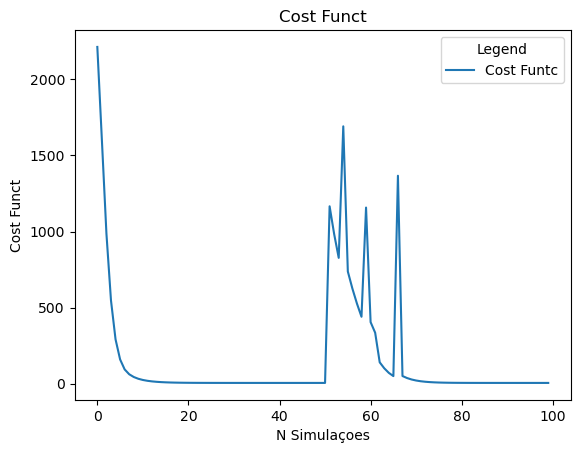

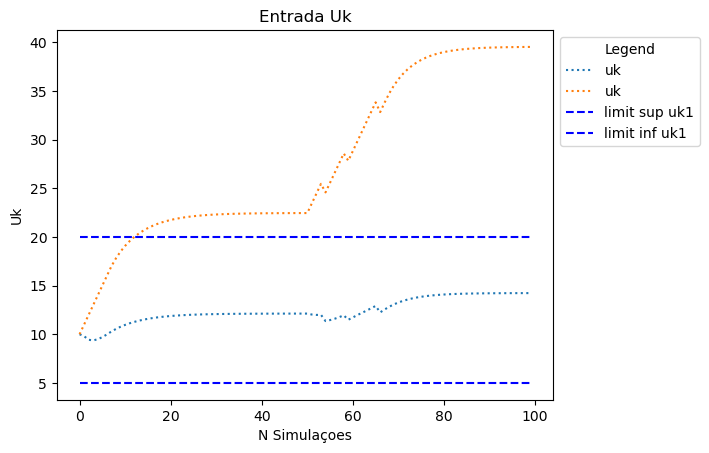

In [7]:
nsim = 100
# plot results
plt.figure(1)
plt.xlabel("N Simulaçoes")
plt.ylabel("Cost Funct")
plt.title("Cost Funct")
aux = []
aux2 = []
for i in range(len(J_k_h)):
    #plt.plot(np.arange(nsim(),[pt[i] for pt in J_k],label = 'id %s'%i)
    aux.append(J_k_h[i][0])
    aux2.append(J_k_h[i][1])

plt.plot(np.arange(nsim),aux2, label='Cost Funtc')
plt.legend(title='Legend', bbox_to_anchor=(1,1))
plt.show()



plt.figure(2)
plt.xlabel("N Simulaçoes")
plt.ylabel("Uk")
plt.title("Entrada Uk")
aux3 = []
aux4 = []
aux10 = []
aux11 = []
for i in range(len(uk_h)):
    #plt.plot(np.arange(nsim),[pt[i] for pt in uk],label = 'id %s'%i)
    aux3.append(uk_h[i][0])
    aux4.append(uk_h[i][1])
    aux10.append(5)
    aux11.append(20)
plt.plot(np.arange(nsim),aux4, label='uk', linestyle=':')
plt.plot(np.arange(nsim),aux10,'b--', label='limit sup uk1')
plt.plot(np.arange(nsim),aux11,'b--', label='limit inf uk1')
plt.legend(title='Legend', bbox_to_anchor=(1,1))
plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


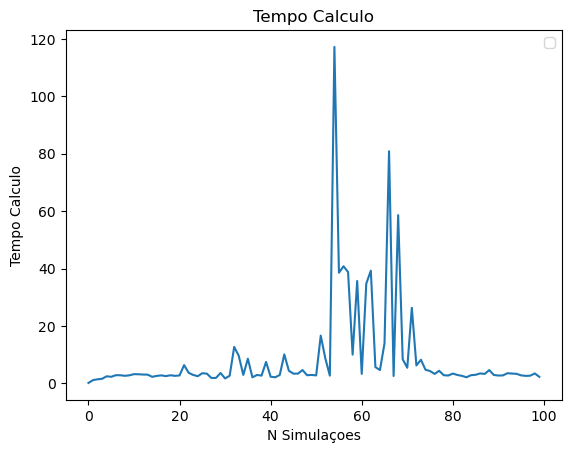

In [8]:

plt.figure(3)
plt.xlabel("N Simulaçoes")
plt.ylabel("Tempo Calculo")
plt.title("Tempo Calculo")
aux5 = []
aux6 = []
for i in range(len(tcalc_h)):
    #plt.plot(np.arange(nsim),[pt[i] for pt in tcalc],label = 'id %s'%i)
    aux5.append(tcalc_h[i][0])
    aux6.append(tcalc_h[i][1])
    
plt.plot(np.arange(nsim),aux6)    
plt.legend()
plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


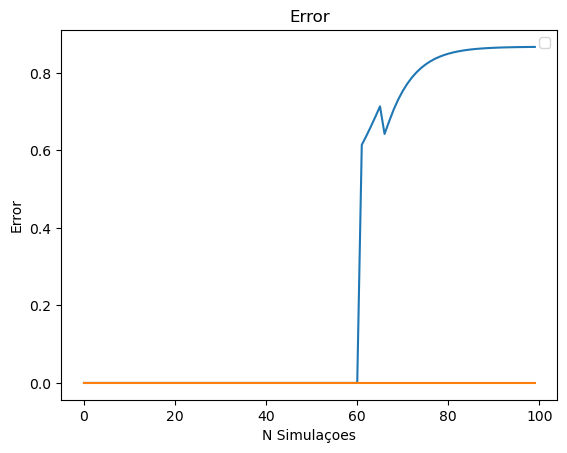

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


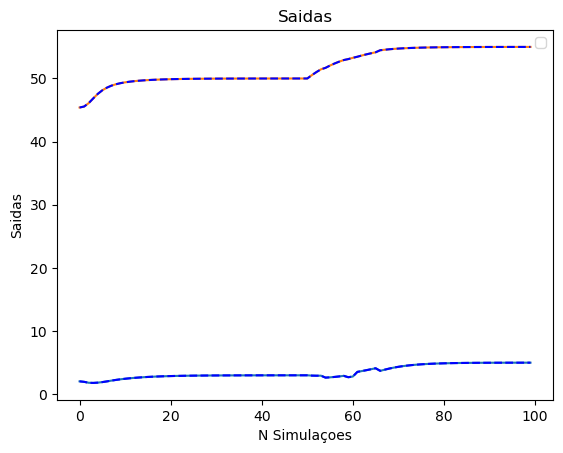

In [9]:


plt.figure(4)
plt.xlabel("N Simulaçoes")
plt.ylabel("Error")
plt.title("Error")
aux7 = []
aux8 = []
for i in range(len(e_h)):
    #plt.plot(np.arange(nsim),[pt[i] for pt in e],label = 'id %s'%i)
    aux7.append(e_h[i][0])
    aux8.append(e_h[i][1])
    
plt.plot(np.arange(nsim),aux8)   
plt.legend()
plt.show()


plt.figure(5)
plt.xlabel("N Simulaçoes")
plt.ylabel("Saidas")
plt.title("Saidas")
aux9 = []
aux10 = []
aux11 = []
aux12 = []
for i in range(len(yp_h)):
    #plt.plot(np.arange(nsim),[pt[i] for pt in yp],label = 'id %s'%i)
    aux9.append(yp_h[i][0])
    aux10.append(yp_h[i][1])
    aux11.append(yp_h[i][0])
    aux12.append(yp_h[i][1])

plt.plot(np.arange(nsim),aux10)   
plt.plot(np.arange(nsim),aux12,'b--')   
plt.legend()
plt.show()
